In [1]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')

In [2]:
import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint


In [3]:
import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


In [12]:
fig_save = Path("./../figures/")

In [5]:
from pathlib import Path

process_path = Path('./../data/processed/')
# p = Path('./')
prmasr_nc = {}
prmasr_nc["L"] = {}
prmasr_nc["S"] = {}
prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
prmasr_nc

{'L': {'18': [PosixPath('../data/processed/ecological_masks/18prmasr0302_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0303_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0304_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0305_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0306_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0307_L.nc'),
   PosixPath('../data/processed/ecological_masks/18prmasr0308_L.nc')],
  '19': [PosixPath('../data/processed/ecological_masks/19prmasr1002_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1003_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1004_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1006_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1007_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1008_L.nc'),
   PosixPath('../data/processed/ecological_masks/19prmasr1009_L.nc')]},


In [6]:
shape =list( process_path.glob('./**/*.shp'))
shape_sorted = sorted((shape))

for i in range(len(shape_sorted)):
    print(i, "\t", shape_sorted[i].name)


0 	 Ecological_classification_Herschel_Island.shp
1 	 gis_osm_landuse_a_free.shp
2 	 gis_osm_water_a_free.shp


In [7]:
ecological_classes = gpd.read_file(shape_sorted[0])
land_mask = gpd.read_file(shape_sorted[1])
lakes_mask = gpd.read_file(shape_sorted[2])

### Plots Ecological Classes

In [8]:
ecological_classes

,OBJECTID,grid_code,Shape_Leng,Shape_Area,UnitName,SOC,TN,IceCont,Legend,Ecological,geometry
0,1,1,2.256879e+04,1.081119e+06,Avadlek,6.09,0.27,0.00,Spits and beaches (Avadlek),Spits and beaches,"MULTIPOLYGON (((574177.721 7713149.207, 574171..."
1,2,2,3.493112e+05,8.619841e+06,Guillemot,84.80,4.55,71.45,Wet Polygonal Terrain (Guillemot),Wet Polygonal Terrain,"MULTIPOLYGON (((574522.000 7713914.000, 574522..."
2,3,3,6.229817e+05,2.819190e+07,Herschel,38.56,3.98,63.67,Hummocky Tussock Tundra (Herschel),Hummocky Tussock Tundra,"MULTIPOLYGON (((574424.500 7713953.000, 574421..."
3,4,4,1.011141e+06,3.503004e+07,Komakuk,39.40,3.43,53.11,Slightly Disturbed Uplands (Komakuk),Slightly Disturbed Uplands,"MULTIPOLYGON (((574258.990 7713798.843, 574262..."
4,5,5,7.672436e+04,1.248412e+06,Orca,42.96,3.47,51.79,Alluvial Fans (Orca),Alluvial Fans,"MULTIPOLYGON (((574322.633 7713950.867, 574314..."
5,6,6,8.639171e+05,2.413968e+07,Plove +Jae,14.41,2.03,15.34,Moderately Disturbed Terrain (Plove +Jae),Moderately Disturbed Terrain,"MULTIPOLYGON (((574502.500 7713901.000, 574486..."
6,7,7,3.842618e+05,1.259380e+07,Thrasher,20.75,3.71,26.73,Strongly Disturbed Terrain (Thrasher),Strongly Disturbed Terrain,"MULTIPOLYGON (((572689.000 7714629.000, 572663..."


In [9]:
colors_hex = ["#4DB65B", "#425DAA", "#F1EB58", "#A4AA56", "#49B0AD", "#A95052", "#74C044"]
color_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove +Jae', 'Thrasher']

ecological_colors = {}
for name, color_hex in zip(color_names, colors_hex):
    ecological_colors[name] = matplotlib.colors.to_rgb(color_hex)
    
print(ecological_colors)


{'Avadlek': (0.30196078431372547, 0.7137254901960784, 0.3568627450980392), 'Guillemot': (0.25882352941176473, 0.36470588235294116, 0.6666666666666666), 'Herschel': (0.9450980392156862, 0.9215686274509803, 0.34509803921568627), 'Komakuk': (0.6431372549019608, 0.6666666666666666, 0.33725490196078434), 'Orca': (0.28627450980392155, 0.6901960784313725, 0.6784313725490196), 'Plove +Jae': (0.6627450980392157, 0.3137254901960784, 0.3215686274509804), 'Thrasher': (0.4549019607843137, 0.7529411764705882, 0.26666666666666666)}


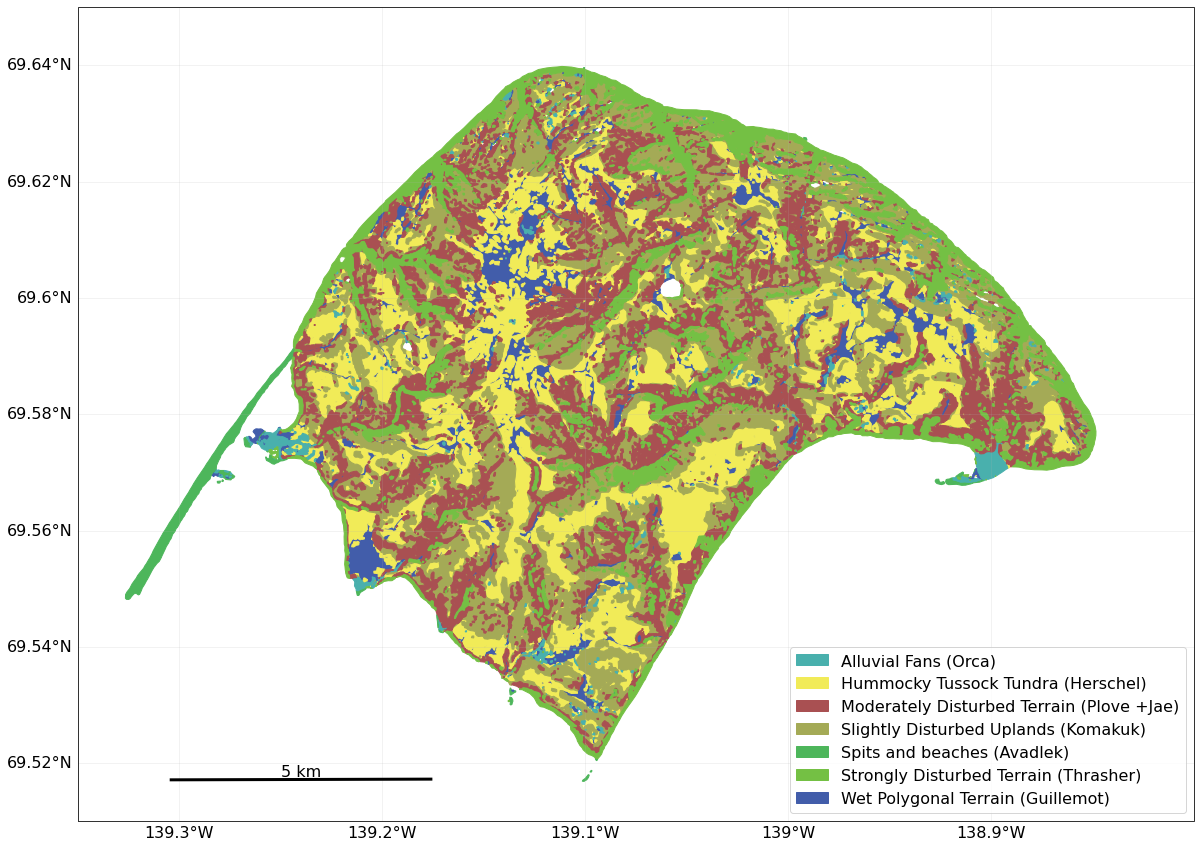

In [14]:
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

extent = [-139.35, -138.8, 69.51,  69.65]          # Extent of Herschel Island in Lat/Long
crs_epsg = ccrs.epsg('3857')
df_epsg = ecological_classes.to_crs(epsg='3857')


# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(20, 20))

ax = pypolsar.plot.map.MapPlot(ax=axs, extend=extent, scale_bar_plot=True, scale_bar_length=5,  scale_bar_location=(0.2, 0.05), scale_bar_linewidth=3)

LegendElement = {}
for UnitName in df_epsg.UnitName:    
    ax.add_geometries(df_epsg['geometry'][ecological_classes.UnitName == UnitName], crs=crs_epsg, \
                      color=ecological_colors[UnitName], label=UnitName)
    legend_name = df_epsg[ecological_classes.UnitName == UnitName]['Legend'].values[0]
    LegendElement[legend_name] = mpatches.Patch(color=ecological_colors[UnitName], label=legend_name)


legend_items = []

[legend_items.append(x) for x in list(dict(sorted(LegendElement.items())).values())]
legend_items


ax.legend(handles = legend_items, loc='lower right')

fig.savefig("")
fig.savefig(fig_save.joinpath("./PNG/", "ecological_map" +".png"))


### Plot differnce and each class on a grid:

0.7

In [146]:
colorbar_ticks( .335, 0.96)

[0.3, 0.5, 0.6, 0.8, 1.0]

In [154]:
def clip_raster_with_shp(raster, shapefile):
    geodf = gpd.read_file(shapefile)
    xds = raster
    clipped = xds.rio.clip(geodf.geometry.apply(mapping), geodf.crs)
    return clipped

def colorbar_ticks(n1, n2):
    round_n = 1
    m0=np.floor(np.round(np.floor( n1*10)/10, round_n) *10)/10                           # colorbar min value
    m4=np.ceil(np.round(np.ceil( n2*10)/10, round_n) *10) / 10                         # colorbar max value
    #m0 = np.floor( n1 * 10 ) / 10   
    #m4 = np.ceil(  n2 * 10 ) / 10  
    
    m1=np.round(1*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 1
    m2=np.round(2*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 2
    m3=np.round(3*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 3
    
    return [m0,m1,m2,m3,m4]

def combine_netcdf(path_18, path_19):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con

def plot_differnce_grid(path_18, path_19, shapefile_clip, save_path=None, extent=None):
    from cartopy import crs as ccrs
    from pyproj import Transformer

    
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    crs_epsg = ccrs.epsg(ds_con.rio.crs.to_epsg())
    transformer = Transformer.from_crs(4326, ds_con.rio.crs.to_epsg())



    for item in pol_key[:]:
        # print(item)
        img_extend = ds_con.rio.bounds()
        fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.epsg(ds_con.rio.crs.to_epsg())},
                            figsize=(5*2, 6*2)) # figsize=(12*1, 8*1)

        
        ax_1 = axs[0, 0]
        ax_2 =  axs[0, 1]
        ax_diff =  axs[1, 0]
        ax_diff_rel =  axs[1, 1]
        """
        ax_1 = axs[0]
        ax_2 =  axs[1]
        ax_diff =  axs[ 2]
        ax_diff_rel =  axs[3]
        """
        
        if extent is not None:
            x1, y1 = transformer.transform(extent[2], extent[0])
            x2, y2 = transformer.transform(extent[3], extent[1])
            ax_1.set_extent([x1, x2, y1, y2], crs=crs_epsg)
            ax_2.set_extent([x1, x2, y1, y2], crs=crs_epsg)
            ax_diff.set_extent([x1, x2, y1, y2], crs=crs_epsg)
            ax_diff_rel.set_extent([x1, x2, y1, y2], crs=crs_epsg)


        img_1 = ds_con[item][ds_con.time == 2018].data[0, 0, :, :]
        if item == "entropy" or item == "anisotropy":
            vmin_1 = 0
            vmax_1 = 1
        #"""        
        elif item == 'alpha':
            vmin_1 = 0
            vmax_1 = 50
        # """
        elif item == 'p_hhvv':
            vmin_1 = 0.5
            vmax_1 = 1.8
        #""" 
        elif item == 'ph_diff_hhvv':
            vmin_1 = -20
            vmax_1 = 40
        #"""
        else:
            vmin_1, vmax_1 = np.nanpercentile(img_1, [2, 98])

        ax_cc_1 = ax_1.imshow(img_1, origin='upper', transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=vmin_1, vmax=vmax_1,
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        fig.colorbar(ax_cc_1, ax=ax_1, shrink=0.8, orientation="vertical",
                    ticks=colorbar_ticks(vmin_1, vmax_1))


        img_2 = ds_con[item][ds_con.time == 2019].data[0, 0, :, :]
        im_perc = np.nanpercentile(img_2, [5, 95])
        ax_cc_2 = ax_2.imshow(img_2, origin='upper', transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=vmin_1, vmax=vmax_1,
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        fig.colorbar(ax_cc_2, ax=ax_2, shrink=0.8, orientation="vertical",
                    ticks=colorbar_ticks(vmin_1, vmax_1))

        img_diff = img_1 - img_2
        im_perc_diff = np.nanpercentile(img_diff, [5, 95])
        ax_cc_diff = ax_diff.imshow(img_diff, origin='upper', transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=im_perc_diff[0], vmax=im_perc_diff[1],
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        
        fig.colorbar(ax_cc_diff, ax=ax_diff, shrink=0.8, 
                     orientation="vertical",
                     # ticks=colorbar_ticks(im_perc_diff[0], im_perc_diff[1])
                    )

        img_diff_rel = np.abs((img_1 - img_2) / (img_1 + np.finfo(float).eps ))
        im_perc_diff_rel = np.nanpercentile(img_diff_rel, [5, 95])
        ax_cc_rel = ax_diff_rel.imshow(img_diff_rel, origin='upper', 
                                       transform=ccrs.epsg(ds_con.rio.crs.to_epsg()), 
                  cmap="jet", vmin=im_perc_diff_rel[0], vmax=im_perc_diff_rel[1],
                  extent=[img_extend[0], img_extend[2], img_extend[1], img_extend[3]])
        
        fig.colorbar(ax_cc_rel, ax=ax_diff_rel, shrink=0.8, 
                     orientation="vertical",
                     # ticks=colorbar_ticks(im_perc_diff_rel[0], im_perc_diff_rel[1])
                    )
        
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
        fig.suptitle(item.title(), fontsize=18)
        ax_1.set_title(path_18.name[:-3] )
        ax_2.set_title(path_19.name[:-3] )
        ax_diff.set_title('Difference (18-19)')
        ax_diff_rel.set_title('Relative Differnce')
        ax_1.set_axis_off()
        ax_2.set_axis_off()
        ax_diff.set_axis_off()
        ax_diff_rel.set_axis_off()


        if save_path is not None:
            fig.savefig(save_path.joinpath(path_18.name[:-3]+ "_" + path_19.name[:-3]  + "_" + item +".png"))
            plt.clf()
             # fig.savefig(process_path.joinpath("./pol_diff/", path_18.name[:-3]+ "_" + path_19.name[:-3] + "_" + item +".png"))
        # fig.savefig(fig_save.joinpath("./PNG/", "./pol_diff/", path_18.name[:-3]+ "_" + path_19.name[:-3] + "_" + item +".png"))
        # fig.savefig(save_path.joinpath(path_18.name[:-3]+ "_" + path_19.name[:-3]  + "_" + item +".png")
        # plt.clf()
        
# plot_differnce_grid(path_18=prmasr_nc["L"]["18"][0], path_19=prmasr_nc["L"]["19"][0], shapefile_clip=shape_sorted[1])



In [119]:
np.floor(90./5) +1

19.0

In [121]:
np.round(52131.56456, 1)

n1 = 0
n2 = 1
round_n = 1
m0=(np.round(n1, round_n))                           # colorbar min value
m4=(np.round(n2, round_n))                          # colorbar max value
m1=np.round(1*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 1
m2=np.round(2*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 2
m3=np.round(3*(m4-m0)/4.0 + m0, round_n )             # colorbar mid value 3

#
#cbar.set_ticks([m0,m1,m2,m3,m4])
#cbar.set_ticklabels([m0,m1,m2,m3,m4])
[m0,m1,m2,m3,m4]

[0, 0.2, 0.5, 0.8, 1]

In [82]:
extent = [-139.35, -138.8, 69.51,  69.65]          # Extent of Herschel Island in Lat/Long

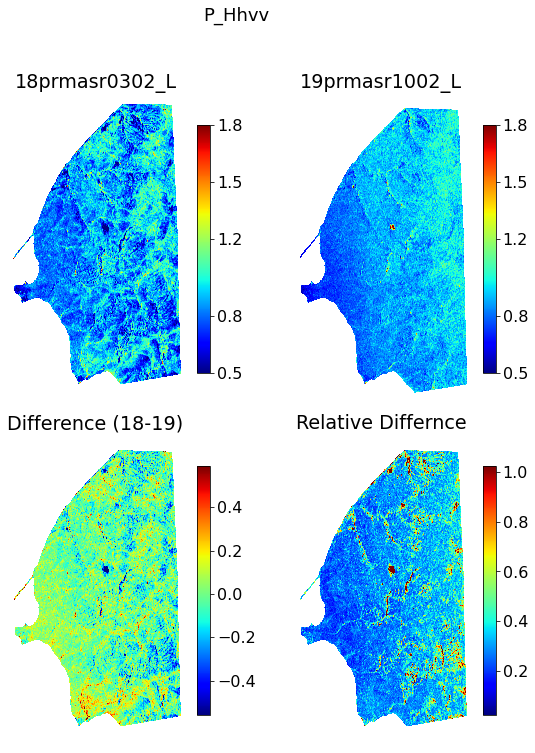

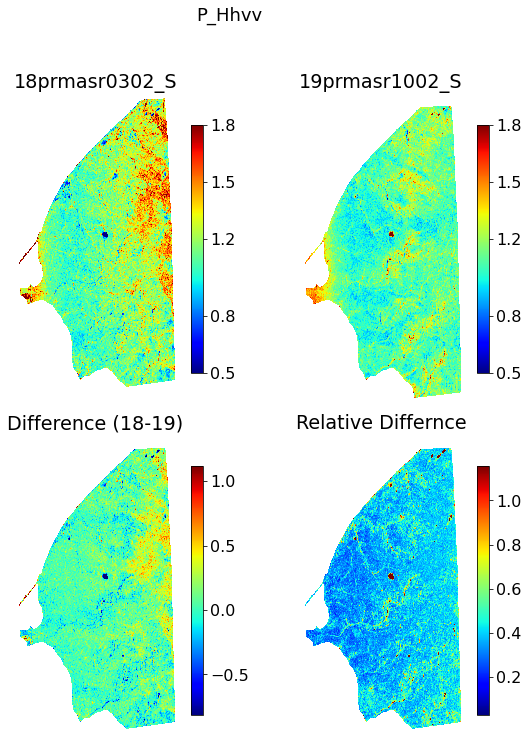

In [155]:
pol_key = []
pol_key.append("p_hhvv")
for path_18, path_19 in zip( prmasr_nc["L"]["18"][0:1], prmasr_nc["L"]["19"][0:1]):
    
    fig_save_name = fig_save.joinpath("./PNG/", "./pol_diff/")
    
    plot_differnce_grid(path_18=path_18, path_19=path_19, shapefile_clip=shape_sorted[1],
                       save_path=None)
    
for path_18, path_19 in zip( prmasr_nc["S"]["18"][0:1], prmasr_nc["S"]["19"][0:1]):
    
    fig_save_name = fig_save.joinpath("./PNG/", "./pol_diff/")
    
    plot_differnce_grid(path_18=path_18, path_19=path_19, shapefile_clip=shape_sorted[1],
                       save_path=None)

In [156]:
pol_key = []
pol_key.append("entropy"   )
pol_key.append("anisotropy" )
pol_key.append("alpha"      )
pol_key.append("p_hhvv"     )
pol_key.append("ph_diff_hhvv")
pol_key

['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv']

In [157]:
for path_18, path_19 in zip( prmasr_nc["L"]["18"][0:], prmasr_nc["L"]["19"][0:]):
    
    fig_save_name = fig_save.joinpath("./PNG/", "./pol_diff/")
    
    plot_differnce_grid(path_18=path_18, path_19=path_19, shapefile_clip=shape_sorted[1],
                       save_path=fig_save_name)


<ipython-input-154-235365d66c63>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.epsg(ds_con.rio.crs.to_epsg())},


<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

In [158]:
for path_18, path_19 in zip( prmasr_nc["S"]["18"][0:], prmasr_nc["S"]["19"][0:]):
    fig_save_name = fig_save.joinpath("./PNG/", "./pol_diff/")

    plot_differnce_grid(path_18=path_18, path_19=path_19, shapefile_clip=shape_sorted[1],
                       save_path=fig_save_name)

<ipython-input-154-235365d66c63>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.epsg(ds_con.rio.crs.to_epsg())},


<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>